In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [3]:
toxic_comments = pd.read_csv('S:/practice/data/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [4]:
toxic_comments.shape

(159571, 8)

In [5]:
toxic_comments.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [6]:
filter = toxic_comments['comment_text'] != ''
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [18]:
print(toxic_comments.loc[201, :])

id                                                007f1839ada915e6
comment_text     Your blatant POV pushing \n\nNeither of you gu...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           0
identity_hate                                                    0
Name: 201, dtype: object


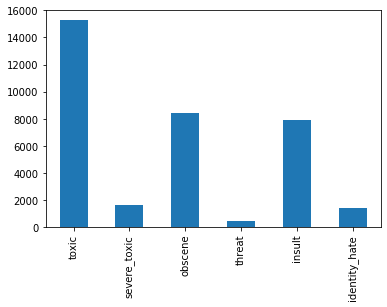

In [19]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.sum(axis=0).plot.bar()

In [20]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('S:/practice/data/glove_embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Approach 1 - 6 neurons in output dense layer

In [23]:
deep_inputs = Input(shape=(maxlen),)
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix],
                           trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
798/798 [==============================] - 435s 545ms/step - loss: 0.1271 - acc: 0.9709 - val_loss: 0.0870 - val_acc: 0.9943
Epoch 2/3
798/798 [==============================] - 433s 542ms/step - loss: 0.0662 - acc: 0.9940 - val_loss: 0.0633 - val_acc: 0.9942
Epoch 3/3
798/798 [==============================] - 397s 497ms/step - loss: 0.0579 - acc: 0.9940 - val_loss: 0.0570 - val_acc: 0.9919


In [26]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 62s 62ms/step - loss: 0.0558 - acc: 0.9919
Test Score: 0.05582667887210846
Test Accuracy: 0.9918533563613892


In [27]:
prediction = model.predict(X_test)

In [47]:
prediction[989]

array([0.08586469, 0.00074124, 0.01808983, 0.0009973 , 0.01603988,
       0.00282893], dtype=float32)

In [46]:
y_test[989]

array([1, 0, 0, 0, 0, 0], dtype=int64)

### Approach 2 - 6 Different Dense layers with single neuron

In [48]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

# Text inputs to embedded vectors
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove_file = open('S:/practice/data/glove_embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [49]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     14824300    input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_3[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         lstm_2[0][0]                     
_______________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=2, verbose=1, validation_split=0.2)

Epoch 1/2
